# Adult census income

Problem statement: Predict whether a person earns >50K or ≤50K per year based on census attributes.

Type: Binary classification

Success Metric: F1 score

## Enviroment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

## Data loading

In [2]:
df_og = pd.read_csv("../datasets/adult_census_income.csv")
df_og.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


our dataframe has a lot of ? that we should replace with null before any kind of EDA or statistical information to properly be able to handle EDA.

In [3]:
df_og.replace("?", np.nan, inplace=True)
df_og.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [4]:
df_og.shape

(32561, 15)

our dataframe has 15 features, each containing 32561 rows.

## Data Understanding - EDA

### Basic information

In [5]:
df_og.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


our dataset has 6 numerical and 9 categorical columns

In [6]:
df_og.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

workclass, occupation and native.country have some null values in them that we will handle later with either mode or dropping them.

#### Conclusions

- our dataset will require atleast basic amount of cleaning and preprocessing

### Statistical information

In [7]:
df_og.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


#### Conclusions

- we have data ranging from 17 years old people to 90 years old with most lying between 28 to 48 years old.
- minimum education years are 1 and maximum years are 16 with most having 9 to 12 years of education.
- most people work 40 to 45 hours per week job.
- most people don't have any capital gain or loss.

### Visualisations

In [8]:
def eda_plots(df: pd.DataFrame):
    num_col = df.select_dtypes(include='number').columns
    cat_col = df.select_dtypes(include='object').columns

    if len(cat_col) > 0:
        n_cols = 3
        n_rows = math.ceil(len(cat_col) / n_cols)

        plt.figure(figsize=(5*n_rows, 5*n_cols))

        for i, col in enumerate(cat_col, 1):
            plt.subplot(n_rows, n_cols, i)
            values = df[col].value_counts()
            top = values.head(5)
            if len(values) > 5:
                top["others"] = values[5:].sum()
            plt.pie(top, labels=top.index, autopct="%1.1f%%", startangle=90)
            plt.title(f"Piechart of {col}")

        plt.suptitle("Categorical Columns - Pie Chart")
        plt.tight_layout()
        plt.show()

    if len(num_col) > 0:
        n_cols = 3
        n_rows = math.ceil(len(num_col) / n_cols)

        plt.figure(figsize=(5 * n_rows, 5 * n_cols))

        for i, col in enumerate(num_col, 1):
            plt.subplot(n_rows, n_cols, i)
            sns.boxplot(df[col].dropna())
            plt.title(f"Boxplot of {col}")

        plt.suptitle("Numerical Columns - Boxplot")
        plt.tight_layout()
        plt.show()

    if len(num_col) > 0:
        n_cols = 3
        n_rows = math.ceil(len(num_col) / n_cols)

        plt.figure(figsize=(5 * n_rows, 5 * n_cols))

        for i, col in enumerate(num_col, 1):
            plt.subplot(n_rows, n_cols, i)
            plt.axvline(df[col].mean(), color="r", linestyle="dashed", linewidth=1)
            sns.histplot(df[col].dropna(), kde=True, bins=30)
            plt.title(f"Histplot of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")

        plt.suptitle("Numerical Columns - Histplot")
        plt.tight_layout()
        plt.show()
    
    if len(num_col) > 1:
        pair = sns.pairplot(df[num_col].dropna())
        pair.figure.suptitle("Numerical Columns - Pairplot", y=1.02)
        plt.show()

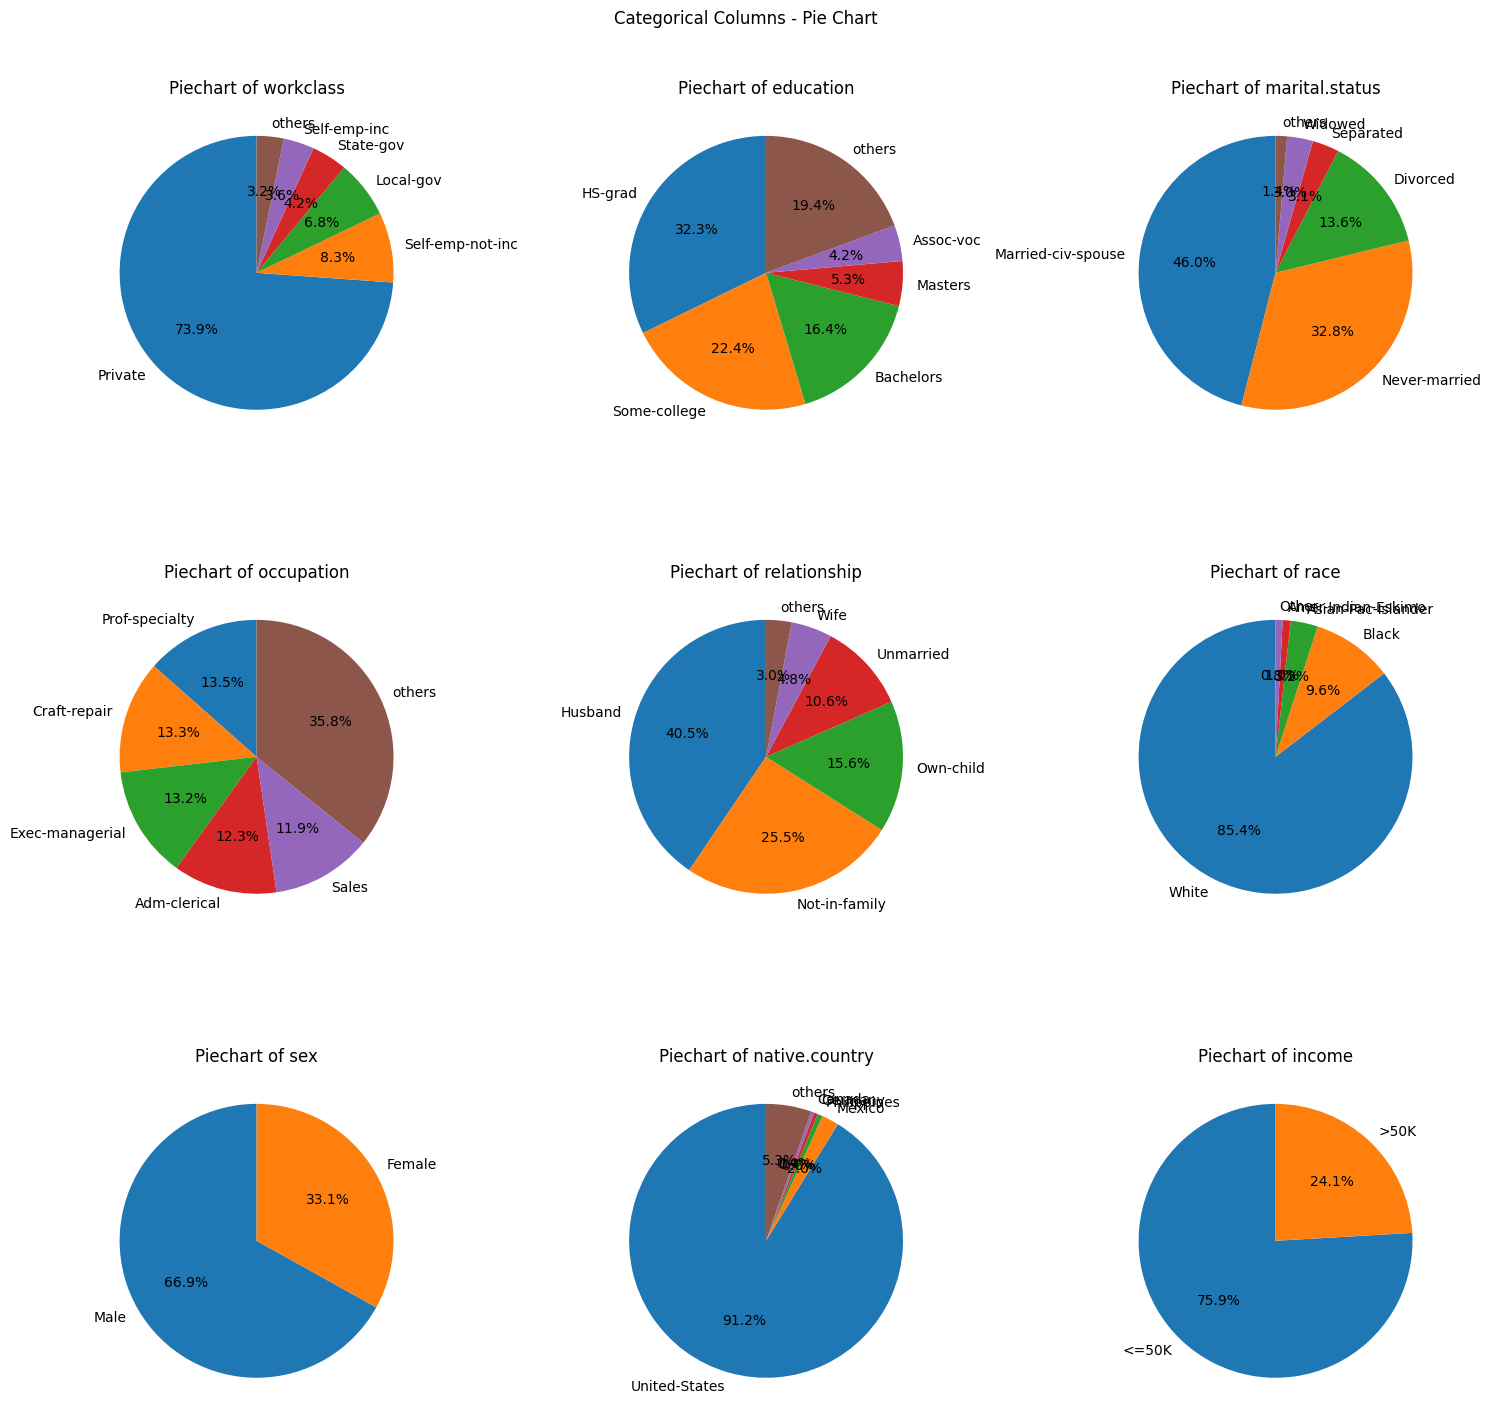

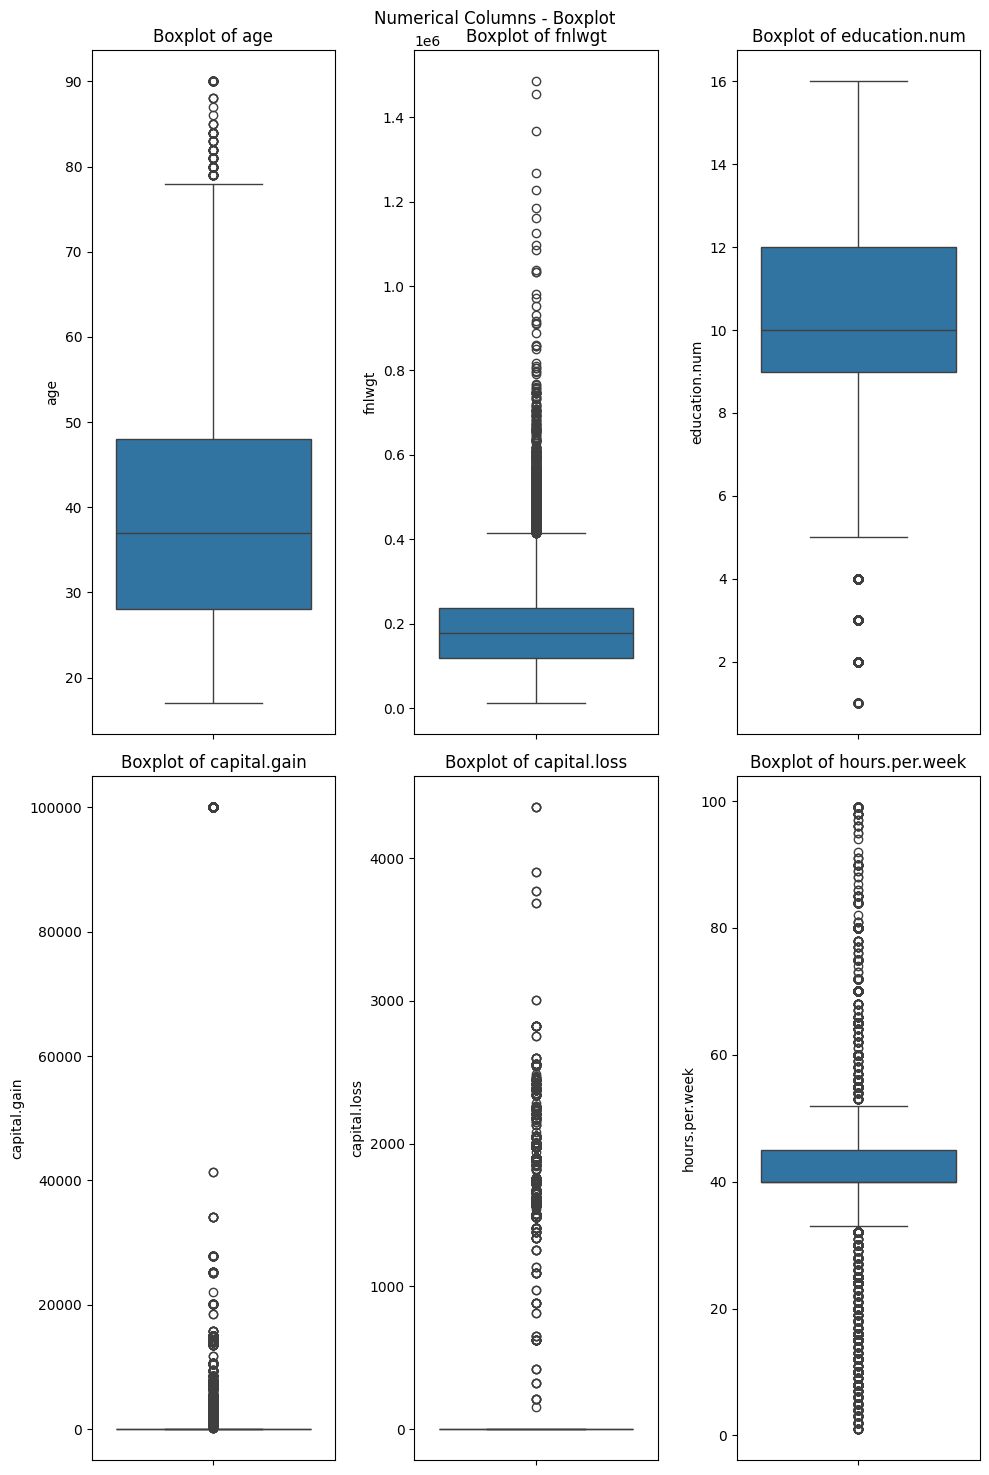

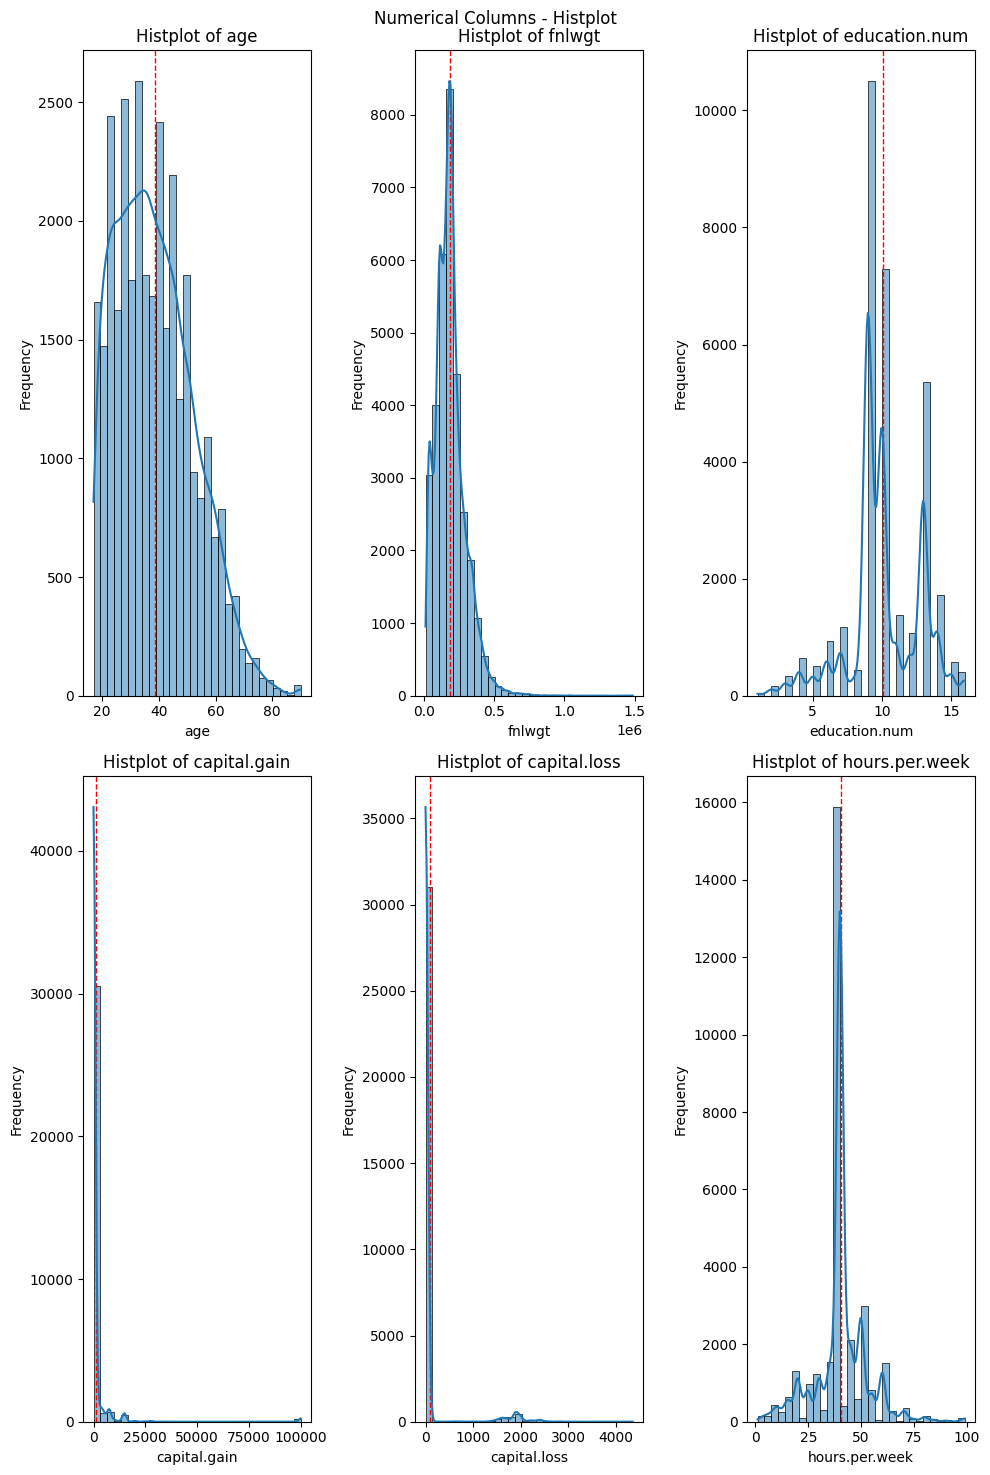

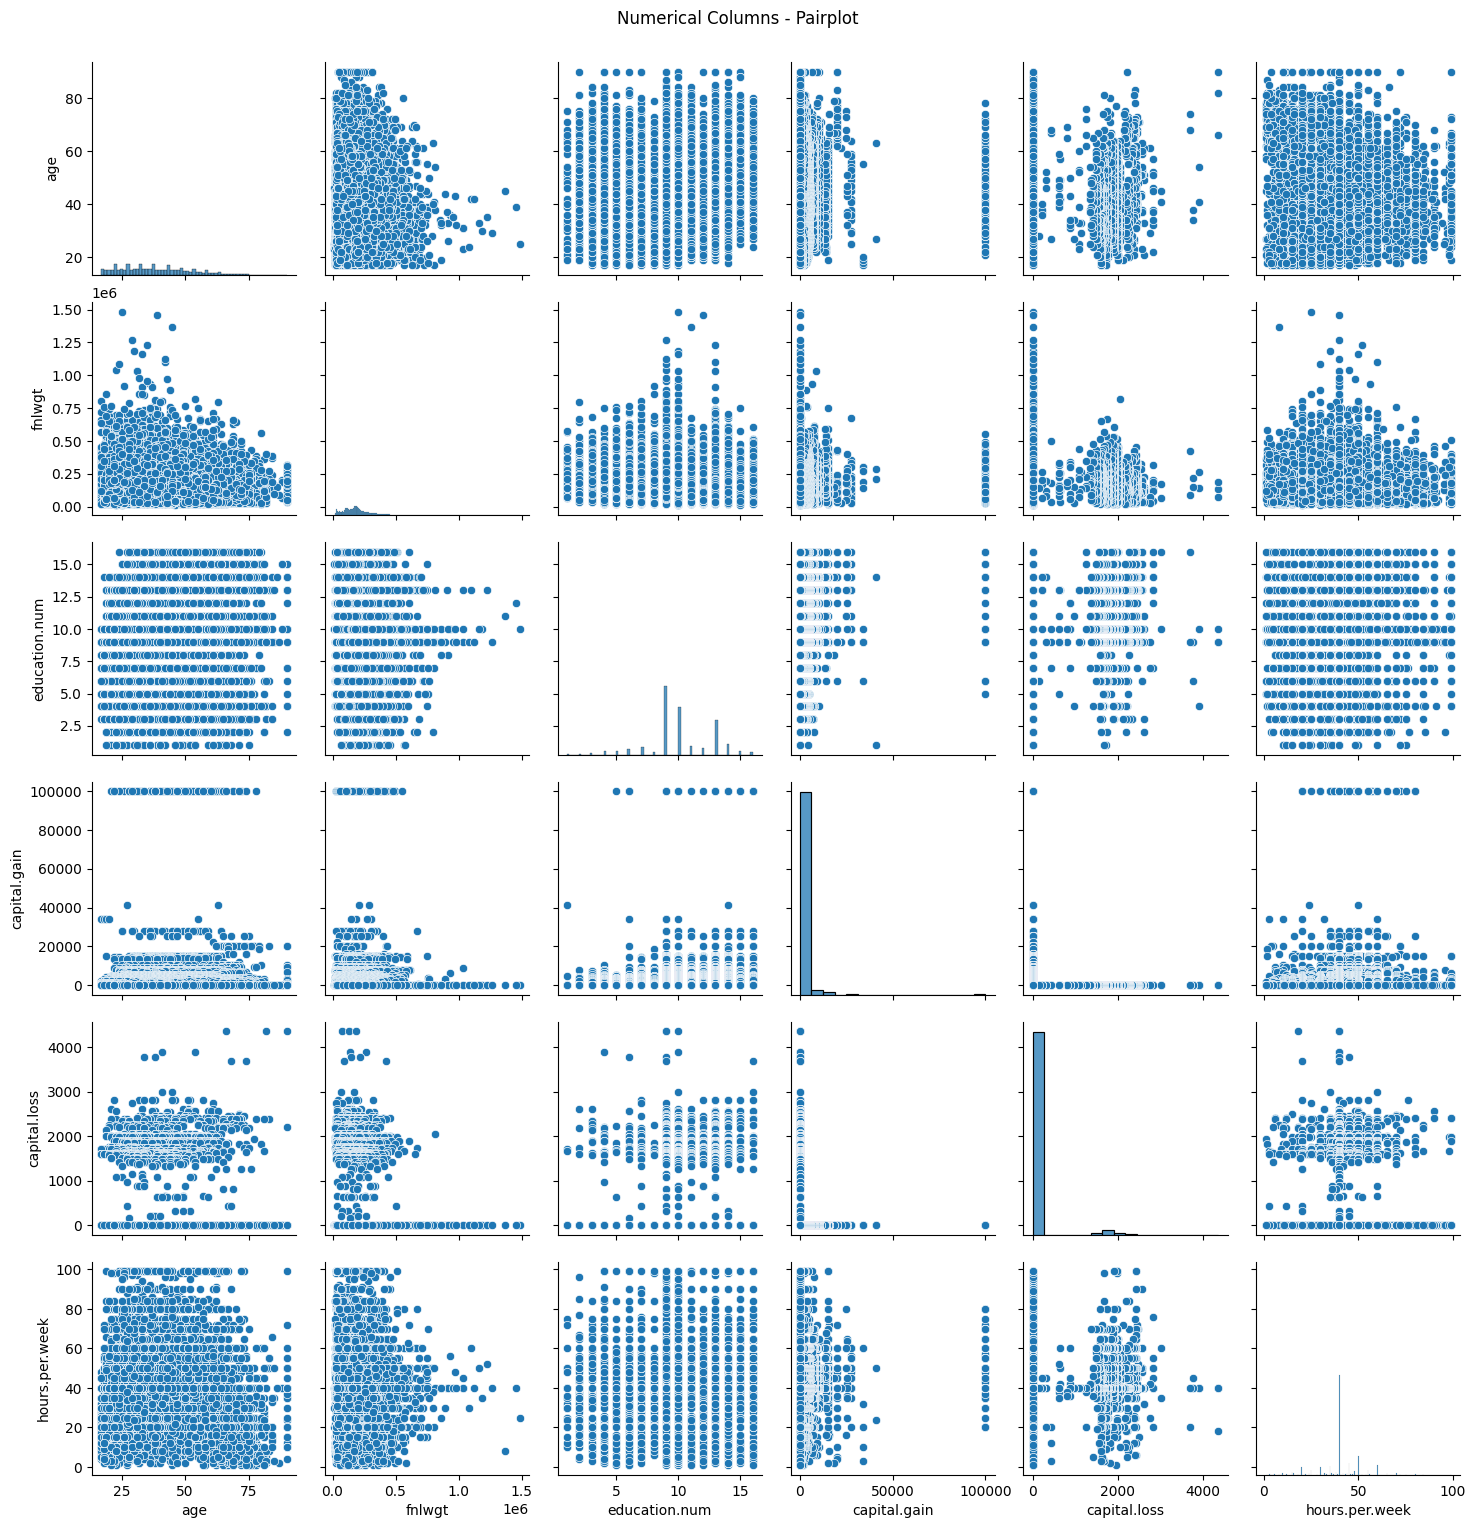

In [9]:
eda_plots(df_og)

#### Conclusions

- Piecharts
    - 74% of the people work at private jobs
    - majority people have atleast graduated from High School.
    - 43% people are married.
    - occupations are fairly distributed between everyone.
    - Most people in this dataset are husbands meaning most household have males as the person who makes money and has an income.
    - Most people in the dataset are white.
    - 67% people in the dataset are males.
    - 92% of the people are natives of US.

- Boxplots
    - our every feature has outliers which we will have to clip in the next part

- Histplots
    - our data is very skewed so we will have to normalise it using Standard Scaler

- Pairplots
    - no feature seems to have a good positive or negative relation with each other.

### Target feature analysis

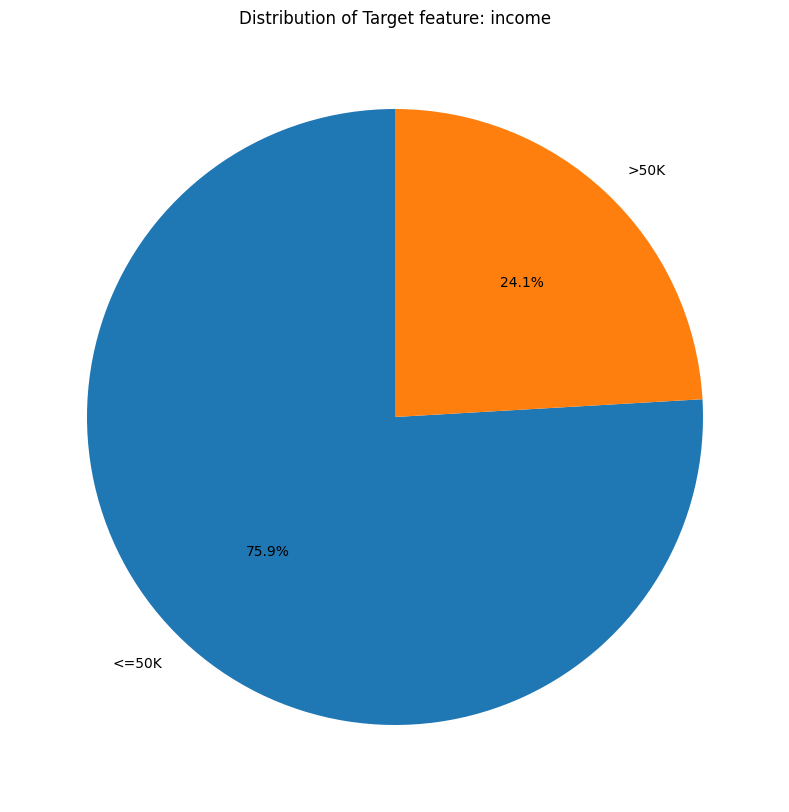

In [10]:
target_feature = "income"

plt.figure(figsize=(15,10))
values = df_og[target_feature].value_counts()
plt.pie(values, labels=values.index, autopct="%1.1f%%", startangle=90)
plt.title(f"Distribution of Target feature: {target_feature}")
plt.show()

#### Conclusions

- 76% people have less than 50k USD income.
- we will have to use startify during train - test split because our target feature is heavily imbalanced.

## Feature selection

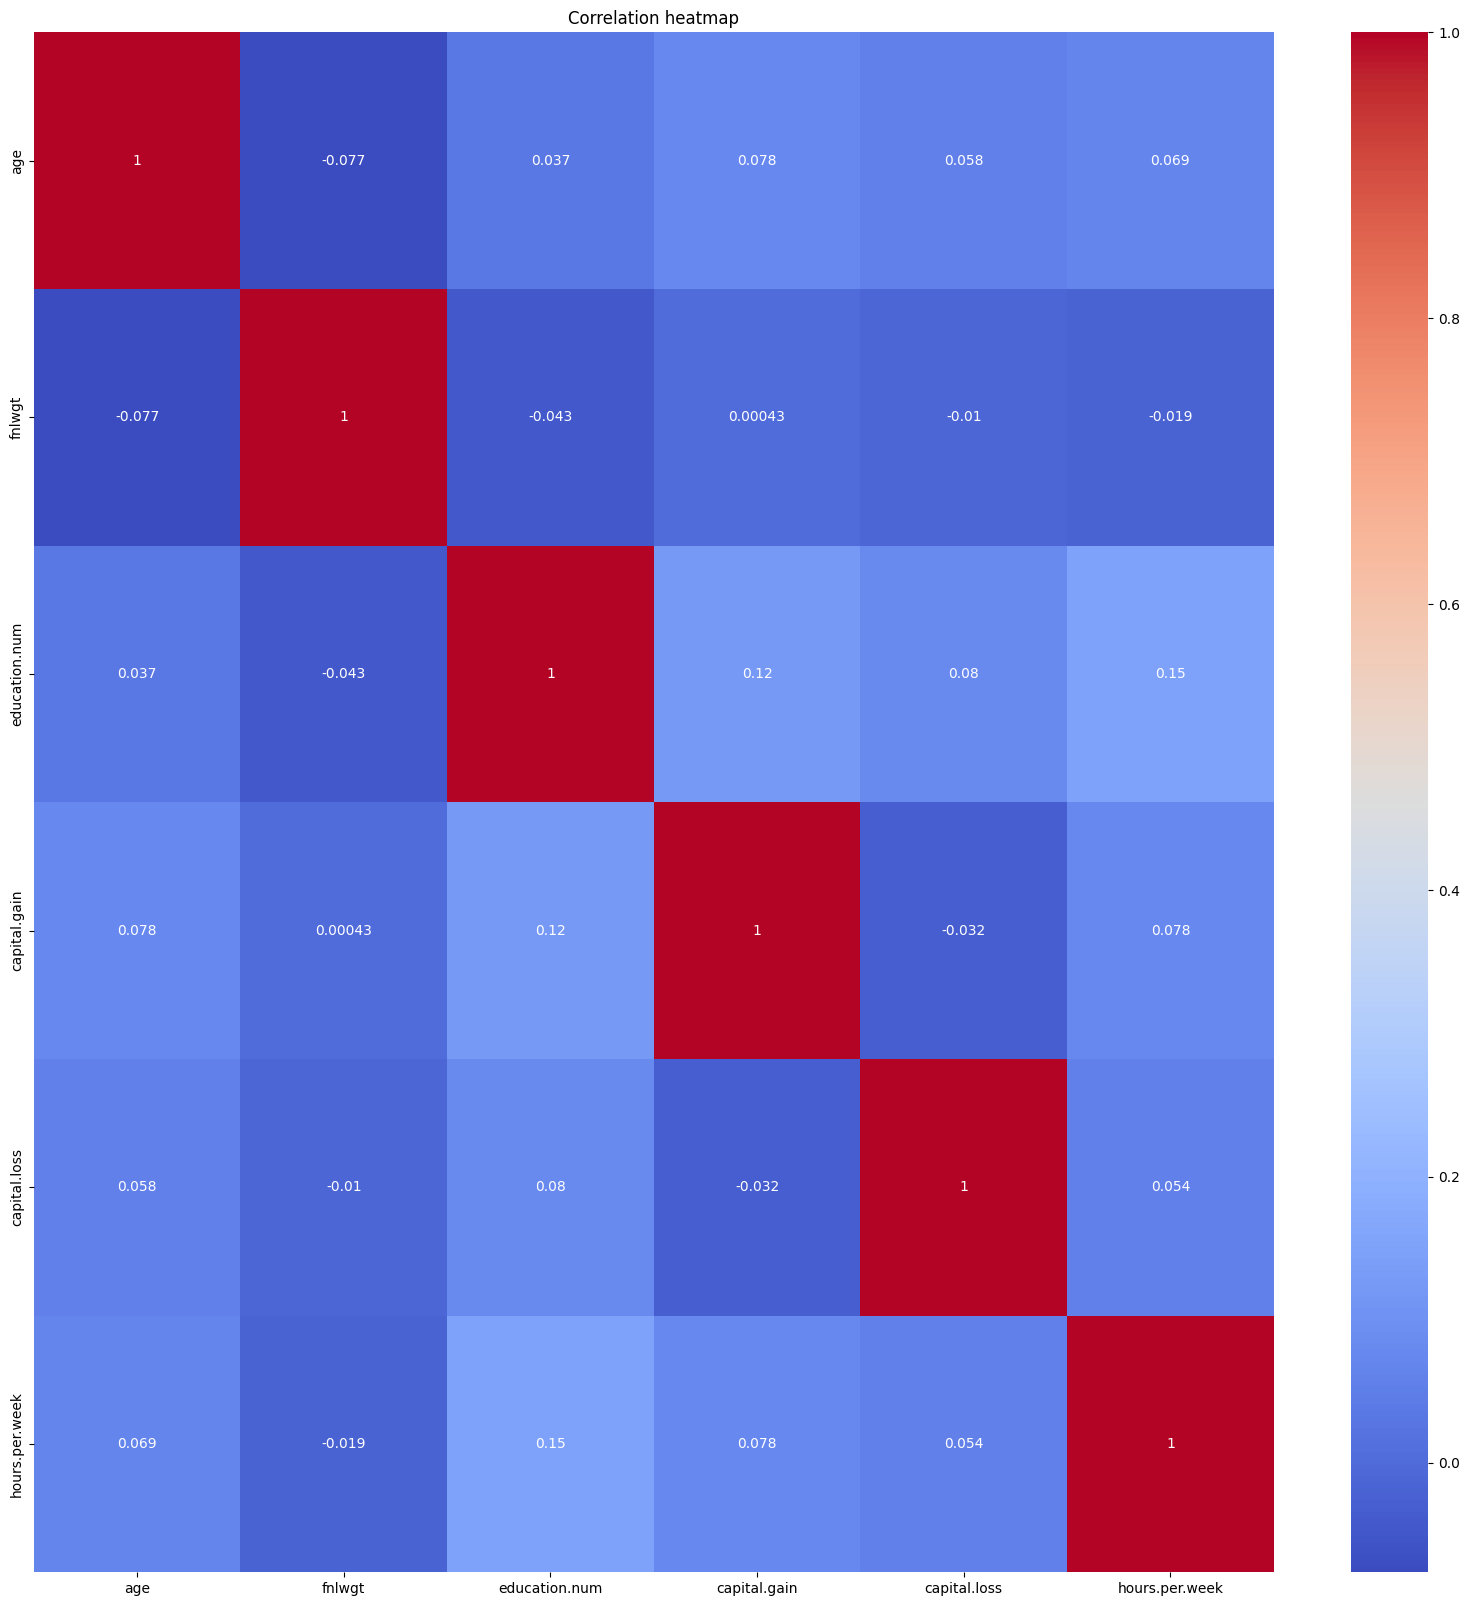

In [11]:
numerical_columns = df_og.select_dtypes(include="number").columns

plt.figure(figsize=(20,20))
sns.heatmap(df_og[numerical_columns].corr(), cmap='coolwarm', annot=True)
plt.title("Correlation heatmap")
plt.show()

there doesn't seem to be any multicollinearity.

In [12]:
X = df_og.drop("income", axis=1)
y = df_og["income"]

we will also label encode `y` so that we can use the same `y` for every model.

In [13]:
le = LabelEncoder()
y = le.fit_transform(y)

print("Label encoding completed")

Label encoding completed


In [14]:
def label_encoding_mapping(label_encoder):
    return dict(
        zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
    )

mapping = label_encoding_mapping(le)
print(mapping)

{'<=50K': np.int64(0), '>50K': np.int64(1)}


- label 0 means <=50K
- label 1 means >50K

below we will write a sklearn class that will let us clip outliers that we can just call directly in our sklearn pipeline.

In [15]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.bounds_ = {}

        num_cols = X.select_dtypes(include="number").columns
        for col in num_cols:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1

            low = Q1 - 1.5 * IQR
            high = Q3 + 1.5 * IQR

            self.bounds_[col] = (low, high)

        return self

    def transform(self, X):
        X = X.copy()

        for col, bounds in self.bounds_.items():
            if col not in X.columns:
                continue

            low, high = bounds
            X[col] = np.clip(X[col], low, high)

        return X

In [16]:
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), make_column_selector(dtype_include='number')),
    ("cat", OneHotEncoder(drop='first', handle_unknown='ignore'), make_column_selector(dtype_include='object'))
])

## Data Splitting

- because our target class is heavily imbalanced, we will use `stratify`
- `random_state = 42` is there for reproducibility

| Test Size | Train Size |
| --------- | ---------- |
| 20%       | 80%        |


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y, test_size=0.2
)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (26048, 14)
y_train shape: (26048,)
X_test shape: (6513, 14)
y_test shape: (6513,)


## Model training - Base model

we will train a basic model so that we know our fancier models aren't just overfitting

In [18]:
lr_pipeline = Pipeline(steps=[
    ("Outlier clipping", OutlierClipper()),
    ("Preprocessing", preprocessor),
    ("model", LogisticRegression())
])
lr_pipeline.fit(X_train, y_train)
lr_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('Outlier clipping', ...), ('Preprocessing', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the differen

In [19]:
y_pred_lr = lr_pipeline.predict(X_test)

print(f"F1: {f1_score(y_test, y_pred_lr)}")

print(f"classification_report\n{classification_report(y_test, y_pred_lr)}")

F1: 0.6254853512177904
classification_report
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      4945
           1       0.70      0.57      0.63      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.74      0.76      6513
weighted avg       0.83      0.84      0.83      6513



now we will check for other models

## Model Selection

In [20]:
lr_pipeline = Pipeline(
    steps=[
        ("Outlier clipping", OutlierClipper()),
        ("Preprocessing", preprocessor),
        ("model", LogisticRegression()),
    ]
)

dt_pipeline = Pipeline(
    steps=[
        ("Outlier clipping", OutlierClipper()),
        ("Preprocessing", preprocessor),
        ("model", DecisionTreeClassifier()),
    ]
)

rf_pipeline = Pipeline(
    steps=[
        ("Outlier clipping", OutlierClipper()),
        ("Preprocessing", preprocessor),
        ("model", RandomForestClassifier()),
    ]
)

svc_pipeline = Pipeline(
    steps=[
        ("Outlier clipping", OutlierClipper()),
        ("Preprocessing", preprocessor),
        ("model", SVC()),
    ]
)

In [21]:
pipelines = {
    "Logistic Regression": lr_pipeline,
    "Decision Tree": dt_pipeline,
    "Random Forest": rf_pipeline,
    "SVC": svc_pipeline,
}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"F1 of {name}: {f1_score(y_test, y_pred)}")
    print(f"Classification repost of {name}:\n {classification_report(y_test, y_pred)}\n")

F1 of Logistic Regression: 0.6254853512177904
Classification repost of Logistic Regression:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90      4945
           1       0.70      0.57      0.63      1568

    accuracy                           0.84      6513
   macro avg       0.79      0.74      0.76      6513
weighted avg       0.83      0.84      0.83      6513


F1 of Decision Tree: 0.5479962721342032
Classification repost of Decision Tree:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4945
           1       0.53      0.56      0.55      1568

    accuracy                           0.78      6513
   macro avg       0.70      0.70      0.70      6513
weighted avg       0.78      0.78      0.78      6513


F1 of Random Forest: 0.6110160793705097
Classification repost of Random Forest:
               precision    recall  f1-score   support

           0       0.87      0.91 

Preformance of all of our models:

Logistic Regression > SVC > Random Forest > Decision Tree

This case shows us why we should always check for a base model as well because sometimes they can be hard to beat with fancier models.

so now we will do hyperparamter tuning on logistic regression

## Hyperparamter tuning - Logistic Regression

we will check for both l1 and l2 regularization

In [22]:
param_grid = [
    {
        "model__penalty": ["l2"],
        "model__solver": ["lbfgs", "liblinear"],
        "model__C": [0.01, 0.1, 1, 10],
        "model__class_weight": [None, "balanced"],
    },
    {
        "model__penalty": ["l1"],
        "model__solver": ["liblinear"],
        "model__C": [0.01, 0.1, 1, 10],
        "model__class_weight": [None, "balanced"],
    },
]

In [23]:
cv = GridSearchCV(lr_pipeline, param_grid, scoring="f1", cv=5, n_jobs=-1, verbose=True)
cv.fit(X_train, y_train)
cv

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model__C': [0.01, 0.1, ...], 'model__class_weight': [None, 'balanced'], 'model__penalty': ['l2'], 'model__solver': ['lbfgs', 'liblinear']}, {'model__C': [0.01, 0.1, ...], 'model__class_weight': [None, 'balanced'], 'model__penalty': ['l1'], 'model__solver': ['liblinear']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 

In [24]:
pipeline = cv.best_estimator_

print(f"Best parameters: {cv.best_params_}")
print(f"Best f1 score: {cv.best_score_}")

Best parameters: {'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best f1 score: 0.6621601295354873


this tells us that we are getting our best logistic model at

- L1 regularisation
- Regularisation strength of 1
- Class weights are kept to balanced

and the best score is f1 on just the training data is 66%

In [25]:
y_pred = pipeline.predict(X_test)

print(f"F1 score: {f1_score(y_test, y_pred)}")
print(f"classification report:\n{classification_report(y_test, y_pred)}\n")
print(f"confusion matrix:\n{confusion_matrix(y_test, y_pred)}")

F1 score: 0.6551724137931034
classification report:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      4945
           1       0.54      0.84      0.66      1568

    accuracy                           0.79      6513
   macro avg       0.74      0.80      0.75      6513
weighted avg       0.84      0.79      0.80      6513


confusion matrix:
[[3822 1123]
 [ 257 1311]]


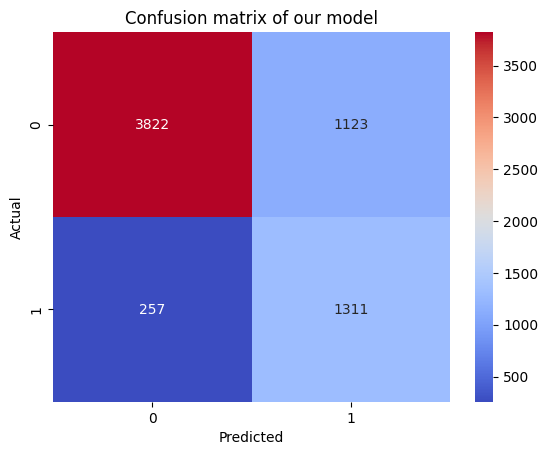

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.title("Confusion matrix of our model")
sns.heatmap(cm, cmap="coolwarm", annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Export the pipeline

we can now export this pipeline to integrate into a dashboard that can allows us to predict from live data using an API

In [27]:
import joblib

try: 
    joblib.dump(pipeline, "adult_income_lr_pipeline.joblib")
except Exception as e:
    print(f"Error occured: {e}")
    
print("Export succesful")

Export succesful


## Summary

- Challange: dataset was imbalanced with 76% people having income less than 50k and 24% people having income >50k.

- Model chosen: Logistic regression with L1 regularisation at C = 1
- other classification models weren't as good as Logistic regression because of either underfitting or overfitting.

- Next step: make a web app in Jinja + flask to do prediction